In [ ]:
from importlib import reload
from load_cluster_data import load_cluster_data
import gc

import numpy as np
import torch
import pandas as pd 
import seaborn as sns
import collections

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

import plotnine as p9

import scipy.sparse as sp

import matplotlib.pyplot as plt 

import nuclear_norm_PCA as knuckle # knuckle: Konvex NUClear norm Konstrained Linear Embedding
import splicing_PCA_utils

# Load data

In [2]:
input_file = '/gpfs/commons/groups/knowles_lab/Karin/parse-pbmc-leafcutter/leafcutter/junctions/PBMC_input_for_LDA.h5'
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_file) # , celltypes = ["B", "MemoryCD4T"])

# still do preprocessing in scipy
indices = (final_data.cell_id_index, final_data.junction_id_index)
indices_np = np.stack(indices)
junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))


['B' 'CD14Mono' 'CD8T' 'DC' 'FCGR3A' 'IGHA' 'MemoryCD4T' 'NK' 'NaiveCD4T'
 'ZNF385D']


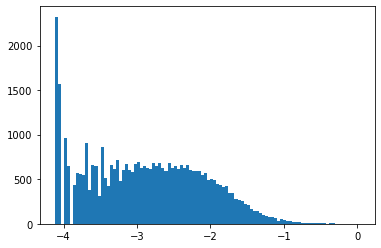

In [3]:
junc_counts_sub, cluster_counts_sub = splicing_PCA_utils.filter_junctions(
    junc_counts, cluster_counts, plot = True)

# Simulate data

In [13]:
sim_junc_counts = splicing_PCA_utils.simulate_junc_counts(
    cluster_counts_sub,
    cell_ids_conversion.cell_type.astype('category')
)

Y_data, w = splicing_PCA_utils.make_Y(
    sim_junc_counts, cluster_counts_sub, float_type) # may we don't need psi? 
Y = torch.tensor(Y_data, **float_type)
W = torch.tensor(w.data, **float_type)

Y_train, W_train, indices_train, Y_test, W_test, indices_test = splicing_PCA_utils.train_test(
    Y_data, w, float_type)

# Testing different optimization parameters

In [17]:

rmseTol = 5e-5 # tolerance for Franke-Wolfe
its = 50 # this is the max number of Franke-Wolfe iterations

# number of iterations for power iteration
power_iteration_control = {
    "increasing_it" : lambda it: (it+2,0.),
    "adapt_tol" : 50, 
    "fixed5" : lambda it: (5,0.), 
    "fixed10" : lambda it: (10,0.), 
    "fixed15" : lambda it: (15,0.), 
    "fixed_tol.01" : lambda it: (100,0.01),
    "fixed_tol.1" : lambda it: (100,0.1),
    "fixed_tol.5" : lambda it: (100,0.5),
    "fixed_tol1" : lambda it: (100,1.) } 

results_ws = {}
results_no_ws = {}

# rs, testErrors, trainErrors, nuc_norms, final_svd, step_times

for pi_name,power_iteration_controller in power_iteration_control.items(): 
    
    results_ws[pi_name] = knuckle.constraint_search(
        indices_train, 
        Y_train, 
        W_train, 
        size = sim_junc_counts.shape,
        indices_test = indices_test, 
        Y_test = Y_test, 
        W_test = W_test, 
        rmseTol = rmseTol, 
        its = its,
        power_iteration_controller = power_iteration_controller,
        **float_type)
    gc.collect()
    
    results_no_ws[pi_name] = knuckle.constraint_search(
        indices_train, 
        Y_train, 
        W_train, 
        size = sim_junc_counts.shape,
        indices_test = indices_test, 
        Y_test = Y_test, 
        W_test = W_test, 
        warm_start = False,
        rmseTol = rmseTol, 
        its = its, # should be higher for no ws
        power_iteration_controller = power_iteration_controller,
        **float_type)
    gc.collect()

1

Conclusion from train/test error and ws/no ws is similar. fixed is faster than increasing, which in turn is faster than adapt. Even on the simulated data ws outperforms no ws, although this could be that 50 PCs is too few for no ws. 
The best option overall seems to be warmstart with a high fixed tolerance (e.g. 1) for the power iteration. Although you can find a fixed number of power iterations that gives comparable performance, it results many more "noise" PCs being included in the final solution (almost twice as many in my run of the sim). 

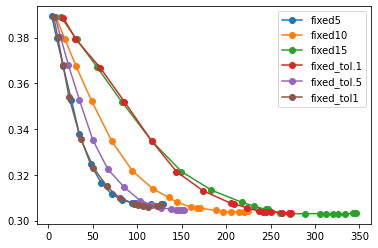

In [71]:
for pi_name,niter in power_iteration_control.items(): 
    rs, testErrors, trainErrors, nuc_norms, final_svd, step_times = results_ws[pi_name]
    plt.plot(np.cumsum(step_times), testErrors, "-o", label = pi_name)
plt.legend()

In [69]:
for pi_name,niter in power_iteration_control.items(): 
    rs, testErrors, trainErrors, nuc_norms, final_svd, step_times = results_no_ws[pi_name]
    print(pi_name, final_svd.U.shape[1])

fixed5 236
fixed10 179
fixed15 167
fixed_tol.1 100
fixed_tol.5 153
fixed_tol1 131


## Run with good settings
Takes about 5min on GPU

In [19]:
rmseTol = 5e-5 # tolerance for Franke-Wolfe
its = 50 # this is the max number of Franke-Wolfe iterations

rs, testErrors, trainErrors, nuc_norms, final_svd, step_times = knuckle.constraint_search(
    indices_train, 
    Y_train, 
    W_train, 
    size = sim_junc_counts.shape,
    indices_test = indices_test, 
    Y_test = Y_test, 
    W_test = W_test, 
    rmseTol = rmseTol, 
    its = its,
    power_iteration_controller = (30,1.),
    **float_type)

/gpfs/commons/home/daknowles/calcutta/leafcutter-sc/src/beta-binomial-lda/nuclear_norm_PCA.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


# Plot results

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

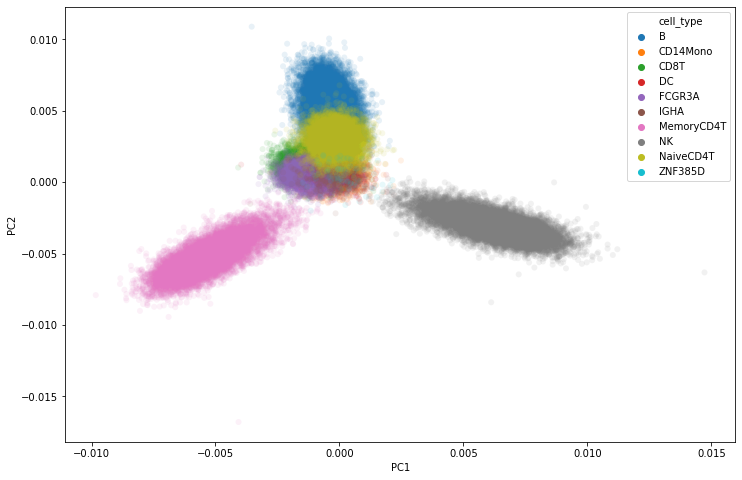

In [20]:
PC_embed_df = pd.DataFrame({"PC1" : final_svd.U[:,0], "PC2" : final_svd.U[:,1]})
PC_embed_df["cell_type"] = cell_ids_conversion["cell_type"].to_numpy()
#p9.ggplot(X_embed_df, p9.aes(x = "x", y="y", color = "cell_type")) + p9.geom_point()

#plt.figure(figsize=[8,6]) # for pdf
plt.figure(figsize=[12,8])
sns.scatterplot(x = "PC1",y = "PC2", hue="cell_type", data= PC_embed_df, edgecolor = 'none', alpha = 0.1)


(0.0, 100.0)

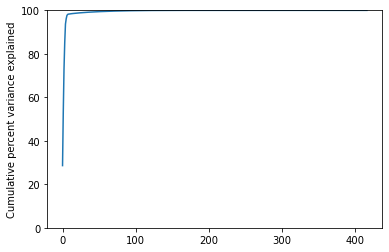

In [75]:
pve = final_svd.S**2
pve /= pve.sum()
pve = pve.cumsum(0) * 100
plt.plot(pve)
plt.ylabel("Cumulative percent variance explained")
plt.ylim(0,100)

# Compare different tSNE preprocessing
We consider four ways of feeding the PCs to tSNE: 
1) Raw U. This overweights low variance PCs and results in a noisy embedding. 
2) Keeping the PCs corresponding to 95% of variance. This is OK but rare cell types get mushed together. 
3) Keeping the PCs corresponding to 95% of variance, and scaling by the singular value. Similar to (2). 
4) Keeping all PCs but scaling by the SVs. This is best in that it separates all cell types, including rare ones. 

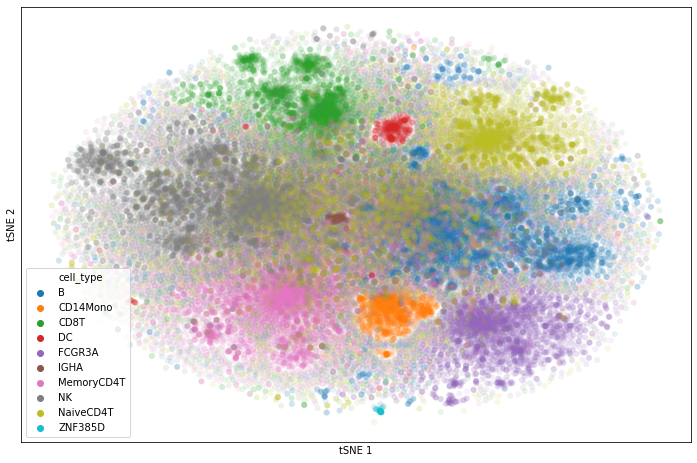

In [82]:
# Keep all PCs, no scaling. Worst. 
knuckle.tsne_plot(final_svd.U, cell_ids_conversion) 

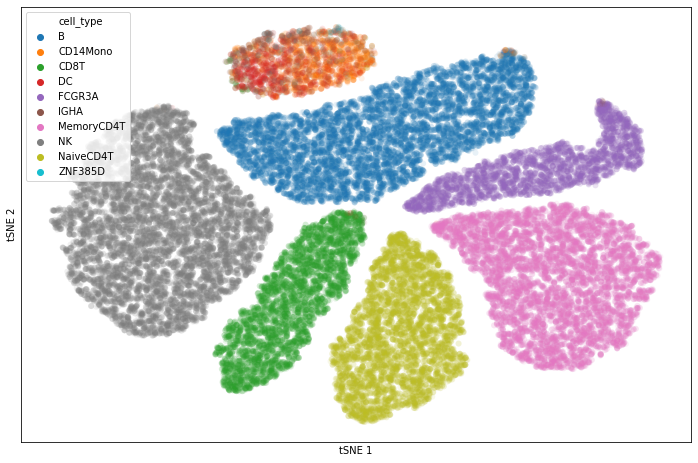

In [83]:
# Keep 95% of variance
to_keep = pve < 95.
knuckle.tsne_plot(final_svd.U[:,to_keep], cell_ids_conversion)  

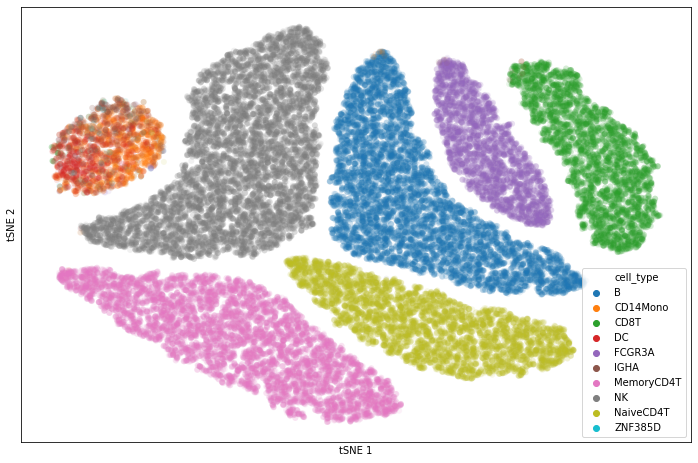

In [86]:
# Keep 95% of variance, and scale by SV
knuckle.tsne_plot(
    final_svd.U[:,to_keep] * final_svd.S[to_keep] , 
    cell_ids_conversion)  

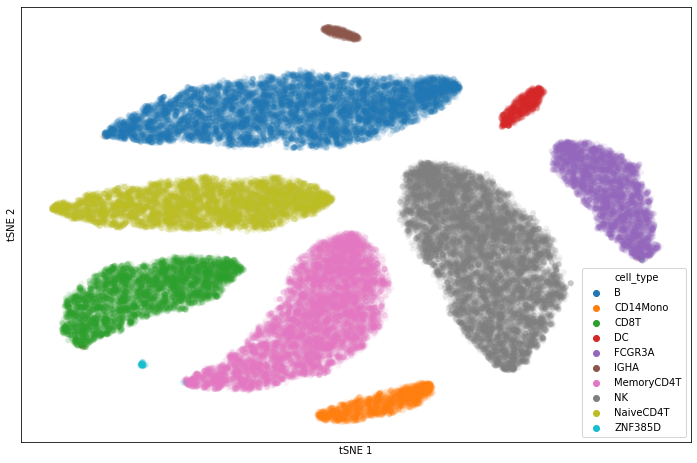

In [87]:
# keep all PCs, but scale by SV. Best in that it keeps the smaller cell types separate. 
knuckle.tsne_plot(
    final_svd.U * final_svd.S, 
    cell_ids_conversion)  